# Classification : 2 Class

## 1.환경준비

### (1) 라이브러리 로딩

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session
from keras.optimizers import Adam

* 학습곡선 함수

In [56]:
# history는 딕셔너리 형태로 저장됨
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

In [57]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/titanic.3.csv"
data = pd.read_csv(path)
data.drop(['Age_scale1', 'AgeGroup', 'SibSp','Parch' ], axis = 1, inplace = True)
data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0,3,male,22.0,7.2500,S,2
1,1,1,female,38.0,71.2833,C,2
2,1,3,female,26.0,7.9250,S,1
3,1,1,female,35.0,53.1000,S,2
4,0,3,male,35.0,8.0500,S,1


## 2.데이터 준비

Sex, Age, Fare 만 이용하여 Survived 를 예측하는 모델을 만들어 봅시다.

### (1) 데이터 준비

In [58]:
target = 'Survived'
features = ['Sex', 'Age', 'Fare']
x = data.loc[:, features]
y = data.loc[:, target]

### (2) 가변수화

In [59]:
x = pd.get_dummies(x, columns = ['Sex'], drop_first = True)
x.head()

,Age,Fare,Sex_male
0,22.0,7.2500,1
1,38.0,71.2833,0
2,26.0,7.9250,0
3,35.0,53.1000,0
4,35.0,8.0500,1


### (3) 데이터분할

In [60]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state = 20)

### (4) Scaling

In [61]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train) # x_train을 기준으로 fitting
x_val = scaler.transform(x_val) # 아까 fitting한 scaler로 x_val 스케일링

## 3.딥러닝1: 3개 feature

### (1) 모델설계

In [62]:
nfeatures = x_train.shape[1]
nfeatures

3

In [63]:
# 메모리 정리
clear_session()

# Sequential 모델 만들기
model = Sequential( Dense( 1 , input_shape = (nfeatures ,), activation= 'sigmoid') ) # output layer인데 활성 함수 有! (0~1) 확률값으로 변환하기 위함

# 모델요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 4 (16.00 Byte)
Trainable params: 4 (16.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### (2) compile + 학습

In [64]:
model.compile(optimizer = Adam(learning_rate=0.01), loss = 'binary_crossentropy') # 이진 분류시 손실함수로 binary crossentropy 사용

history = model.fit(x_train, y_train, epochs = 50, validation_split=0.2).history

Epoch 1/50
16/16 [==============================] - 1s 13ms/step - loss: 0.6150 - val_loss: 0.5944
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.6023 - val_loss: 0.5819
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.5916 - val_loss: 0.5710
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.5809 - val_loss: 0.5616
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.5724 - val_loss: 0.5533
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 0.5644 - val_loss: 0.5463
Epoch 7/50
16/16 [==============================] - 0s 6ms/step - loss: 0.5576 - val_loss: 0.5398
Epoch 8/50
16/16 [==============================] - 0s 7ms/step - loss: 0.5518 - val_loss: 0.5339
Epoch 9/50
16/16 [==============================] - 0s 6ms/step - loss: 0.5461 - val_loss: 0.5292
Epoch 10/50
16/16 [==============================] - 0s 5ms/step - loss: 0.5415 - val_loss: 0.5247
Epoch 11/50
16/16 

* 학습결과 그래프

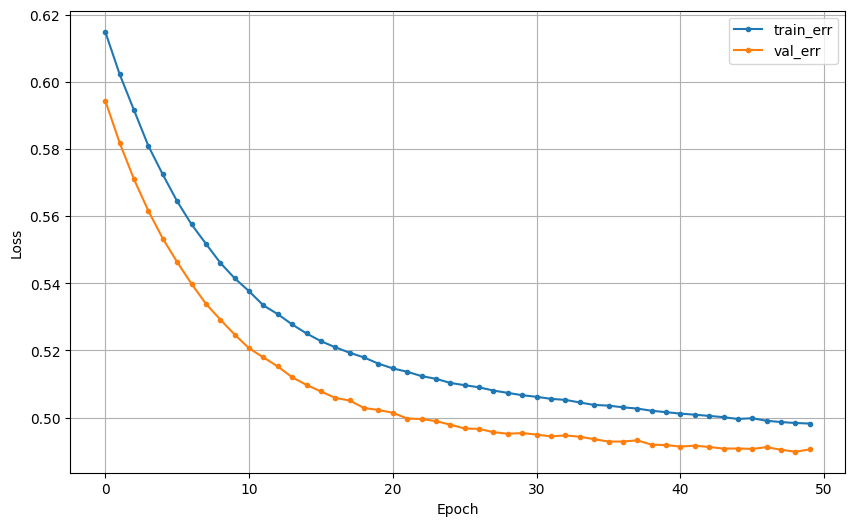

In [65]:
dl_history_plot(history)

### (3) 예측 및 검증

In [66]:
pred = model.predict(x_val)
#pred[:5]

# activation이 sigmoid --> 0 ~ 1 사이의 확률값.
# 그러므로 cut-off value(보통 0.5)를 기준으로 잘라서 0과 1로 만들어 준다.
pred = np.where(pred >= .5, 1, 0)
pred[:5]

9/9 [==============================] - 0s 2ms/step


array([[1],
       [0],
       [0],
       [0],
       [1]])

In [67]:
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       170
           1       0.73      0.68      0.71        98

    accuracy                           0.79       268
   macro avg       0.78      0.77      0.77       268
weighted avg       0.79      0.79      0.79       268



## 4.딥러닝2 : 전체 feature
* 이제 전체 데이터를 가지고 모델링을 시도해 보겠습니다.


### (1) 데이터 전처리

* 데이터 준비

In [68]:
target = 'Survived'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

* 가변수화

In [69]:
cat_cols = ['Pclass','Sex', 'Embarked']
x = pd.get_dummies(x, columns = cat_cols, drop_first = True)

* 데이터분할

In [70]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state = 20)

* 스케일링

In [71]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

### (2) 모델링

* 모델 설계

In [72]:
nfeatures=x_train.shape[1]
nfeatures

8

In [73]:
# 메모리 정리
clear_session()

# Sequential 모델
model = Sequential( Dense(1, input_shape = (nfeatures, ),  activation = 'sigmoid'))

# 모델요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 9 (36.00 Byte)
Trainable params: 9 (36.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* compile + 학습

In [74]:
model.compile(optimizer=Adam(learning_rate=0.03), loss='binary_crossentropy')
history = model.fit(x_train, y_train, epochs=100, validation_split= .3, verbose=0).history

* 학습결과 그래프

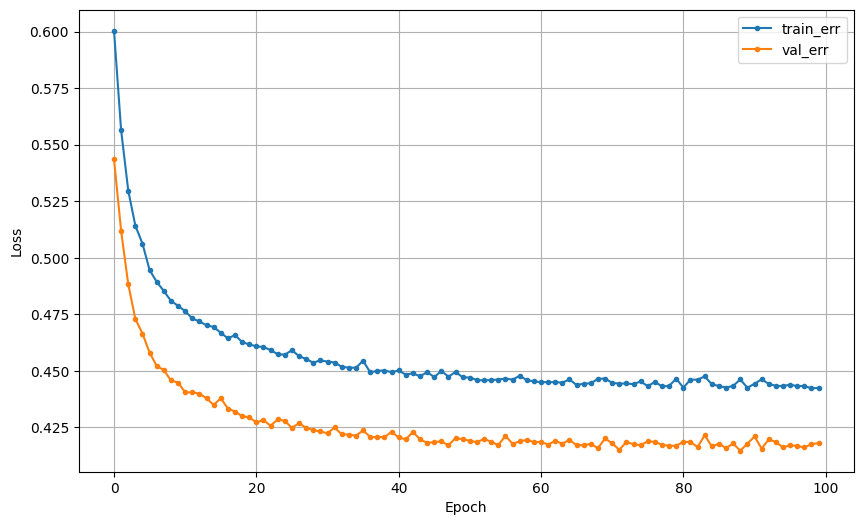

In [75]:
dl_history_plot(history)

* 예측 및 검증

In [76]:
y_pred = model.predict(x_val)
y_pred = np.where(y_pred>=.5, 1, 0)
print(classification_report(y_val, y_pred))

9/9 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       170
           1       0.72      0.66      0.69        98

    accuracy                           0.78       268
   macro avg       0.77      0.76      0.76       268
weighted avg       0.78      0.78      0.78       268



----

## 5.딥러닝3 : hidden layer
* 이제 레이어를 추가해 보겠습니다.


### (1) 모델 설계

In [91]:
n = x_train.shape[1]
n

8

In [92]:
# 메모리 정리
clear_session()

# Sequential 모델
model3 = Sequential([ Dense( 4, input_shape = (n ,), activation = 'relu'),
                      Dense( 1, activation = 'sigmoid')])

# 모델요약
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 36        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 41 (164.00 Byte)
Trainable params: 41 (164.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### (2) compile + 학습

In [93]:
model3.compile( optimizer=Adam(learning_rate= 0.025), loss ='binary_crossentropy')
hist = model3.fit(x_train, y_train, epochs = 100, validation_split=.2, verbose=0).history

* 학습결과 그래프

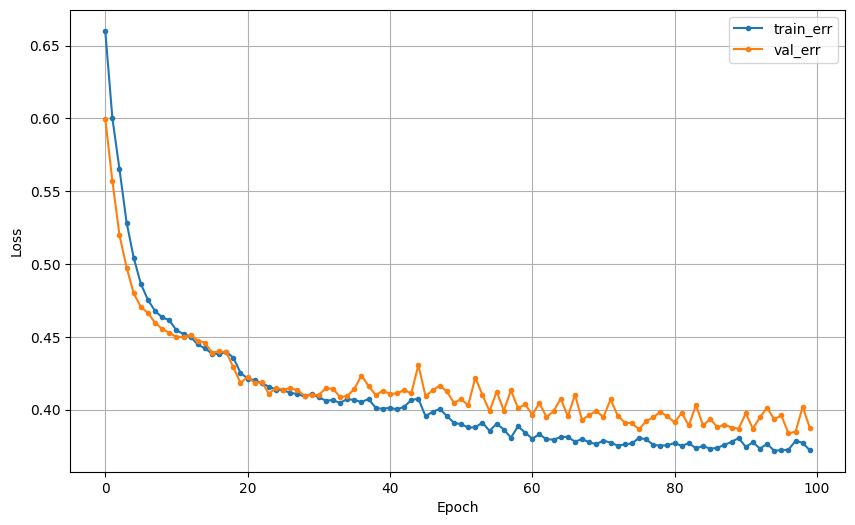

In [94]:
dl_history_plot(hist)

* 예측 및 검증

In [95]:
pred3 = model3.predict(x_val)
pred3 = np.where(pred3 >= 0.5, 1, 0)

9/9 [==============================] - 0s 2ms/step


In [96]:
print(classification_report(y_val, pred3))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       170
           1       0.79      0.61      0.69        98

    accuracy                           0.80       268
   macro avg       0.80      0.76      0.77       268
weighted avg       0.80      0.80      0.79       268



### (3) 실습1

* 다음의 summary를 보고 모델을 설계하시오.

| Layer (type) | Output Shape | 옵션 |
| ---- | ---- | ---- |
| dense (Dense) | (None, 16)  | node, input_shape, activation = 'relu' |
| dense_1 (Dense) | (None, 1) | node, activation = 'sigmoid' |     

In [134]:
clear_session()

model = Sequential([
    Dense(16, input_shape=(n, ), activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 161 (644.00 Byte)
Trainable params: 161 (644.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [135]:
model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy')
history = model.fit(x_train, y_train, epochs=50, validation_split=.5, verbose=0).history

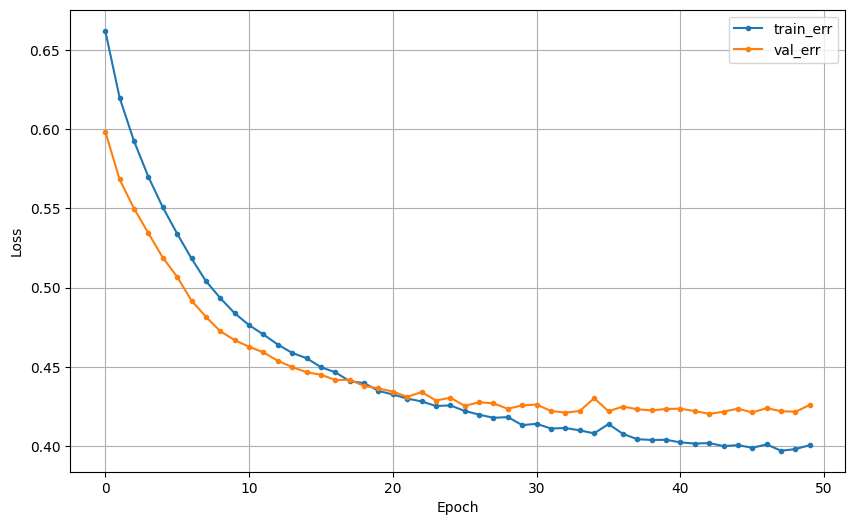

In [136]:
dl_history_plot(history)

In [139]:
y_pred = model.predict(x_val)
y_pred = np.where(y_pred>=.5, 1,0) # equal 빼고 딱히 성능엔 별 차이 X

9/9 [==============================] - 0s 3ms/step


In [140]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       170
           1       0.75      0.59      0.66        98

    accuracy                           0.78       268
   macro avg       0.77      0.74      0.75       268
weighted avg       0.78      0.78      0.77       268



### (4) 실습2

* 다음의 summary를 보고 모델을 설계하시오.

| Layer (type) | Output Shape |  옵션 |
| ---- | ---- | ---- |
| dense (Dense) | (None, 16) |  node, input_shape, activation = 'relu' |
| dense_1 (Dense) | (None, 8) |  node, activation = 'relu'  |
| dense_2 (Dense) | (None, 1) |  node, activation = 'sigmoid'  |

In [161]:
clear_session()
model = Sequential([
    Dense(16, input_shape=(n, ), activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 289 (1.13 KB)
Trainable params: 289 (1.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [162]:
model.compile(optimizer=Adam(learning_rate=0.007), loss='binary_crossentropy')
history = model.fit(x_train, y_train, epochs=50, validation_split=.2, verbose=0).history

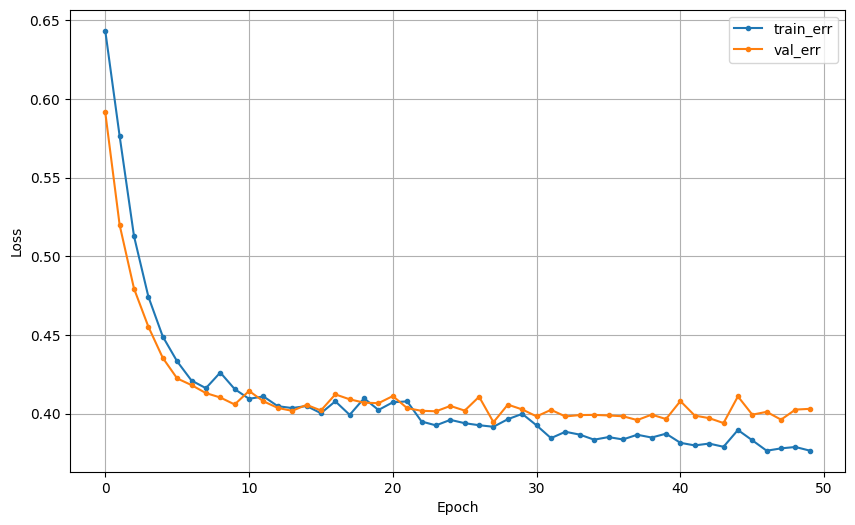

In [163]:
dl_history_plot(history)

In [164]:
y_pred = model.predict(x_val)
y_pred = np.where(y_pred>=.5, 1, 0)
print(classification_report(y_val, y_pred))

9/9 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.81      0.88      0.85       170
           1       0.76      0.64      0.70        98

    accuracy                           0.79       268
   macro avg       0.78      0.76      0.77       268
weighted avg       0.79      0.79      0.79       268

